In [1]:
## imports
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# get data
startup = pd.read_csv("investments_VC.csv")

#checking null value
#startup.isnull().sum(axis = 0)


# 1-Cleaning the data

In [2]:
## to remove spaces in columns names
startup.columns = startup.columns.str.strip()

#removing deplicates
startup = startup.drop_duplicates()

#Drop the rows where all elements are missing.
startup.dropna(how='all')

## permalink and homepage_url irrelveant columns 
## market can replace category list column
#drop founded month , year , quarter since founded_at column contains the whole data
startup.drop(['permalink', 'homepage_url' , 'category_list' , 'founded_month','founded_quarter','founded_year'],
             axis='columns',inplace=True) 

#remove duplicates 
startup = startup.drop_duplicates()

#there is one last row with null value in most column so it will be dropped
startup = startup[pd.notnull(startup['seed'])]

#drop the row with null name as it has NaN in most columns
startup = startup[pd.notnull(startup['name'])]

# convert to float and remove "-" value from the column and replace the "," to be able to convert 
startup['funding_total_usd'] = startup['funding_total_usd'].apply(lambda x: '0' if x == ' -   ' else x)
startup['funding_total_usd'] = startup['funding_total_usd'].str.replace(',', '').astype(float)

#convert founded_at , first funding at , last funding at to datetime datatype
startup['founded_at'] = pd.to_datetime(startup['founded_at'], format='%Y%m%d', errors='coerce')
startup['first_funding_at'] = pd.to_datetime(startup['first_funding_at'], format='%Y%m%d', errors='coerce')
startup['last_funding_at'] = pd.to_datetime(startup['last_funding_at'], format='%Y%m%d', errors='coerce')

#drop rows with status unknown 
startup = startup[pd.notnull(startup['status'])]

#replacing NaT with 0 
startup['founded_at'].replace({pd.NaT: 0}, inplace=True)
startup['first_funding_at'].replace({pd.NaT: 0}, inplace=True)
startup['last_funding_at'].replace({pd.NaT: 0}, inplace=True)




# 2-EDA

In [ ]:

#calculate top 10 markets
market_count = startup.groupby(['market']).size().to_frame().sort_values([0], ascending = False).head(10).reset_index()
market_count = market_count.rename(columns={0:'count'})

#visualize the top 10 marktets
market_hist = px.histogram(market_count, x="market", y="count" )
market_hist.show("png")

##*******************************************************************************


#calculate the sum of each round investment 
sum_of_rounds = (startup[['round_A','round_B' ,'round_C', 'round_D','round_E','round_F' ,'round_G', 'round_H']].sum())
#create new df to hold the sum and the labels
rounds = pd.DataFrame(data=sum_of_rounds)
rounds['Round']= ['round_A','round_B' ,'round_C', 'round_D','round_E','round_F' ,'round_G', 'round_H']
rounds.columns = ['Sum','Round']

#visualize the round investment
fig = px.histogram(rounds , y = 'Sum' , x = 'Round')
fig.show("png")




In [ ]:
##*********************************************************************************

#Markets with most acquired startups
Acquired_market = startup.loc[startup['status'] == 'acquired']
Acquired_market_count = Acquired_market.groupby(['market']).size().to_frame().sort_values([0], ascending = False).head(10).reset_index()
Acquired_market_count  = Acquired_market_count.rename(columns={0:'count'})
#visualize
Acquired_market_hist = px.histogram(Acquired_market_count, x="market", y="count" )
Acquired_market_hist.show("png")

#Markets with least acquired startups
least_acquired_market_count = Acquired_market.groupby(['market']).size().to_frame().sort_values([0], ascending = False).tail(10).reset_index()
least_acquired_market_count  = least_acquired_market_count.rename(columns={0:'count'})
#visualize
least_acquired_market_hist = px.histogram(least_acquired_market_count, x="market", y="count" )
least_acquired_market_hist.show("png")

In [ ]:
##*********************************************************************************

#Markets with most closed startups
Closed_market = startup.loc[startup['status'] == 'closed']
Closed_market_count = Closed_market.groupby(['market']).size().to_frame().sort_values([0], ascending = False).head(10).reset_index()
Closed_market_count  = Closed_market_count.rename(columns={0:'count'})
#visualize
Closed_market_hist = px.histogram(Closed_market_count, x="market", y="count" )
Closed_market_hist.show("png")

#Markets with least closed startups
least_Closed_market_count = Closed_market.groupby(['market']).size().to_frame().sort_values([0], ascending = False).tail(10).reset_index()
least_Closed_market_count  = least_Closed_market_count.rename(columns={0:'count'})
#visualize
least_Closed_market_hist = px.histogram(least_Closed_market_count, x="market", y="count" )
least_Closed_market_hist.show("png")

In [ ]:
#Markets with most operating startups
operating_market = startup.loc[startup['status'] == 'operating']
operating_market_count = operating_market.groupby(['market']).size().to_frame().sort_values([0], ascending = False).head(10).reset_index()
operating_market_count  = operating_market_count.rename(columns={0:'count'})

operating_market_count
#visualize
operating_market_hist = px.histogram(operating_market_count, x="market", y="count" )
operating_market_hist.show("png")

#Markets with least operating startups
least_operating_market_count = operating_market.groupby(['market']).size().to_frame().sort_values([0], ascending = False).tail(10).reset_index()
least_operating_market_count  = least_operating_market_count.rename(columns={0:'count'})
#visualize
least_operating_market_hist = px.histogram(least_operating_market_count, x="market", y="count" )
least_operating_market_hist.show("png")

# 3- Dealing with imbalanced classes

In [3]:

#encoding all categorical columns
for column in startup[['name' , 'market' , 'country_code' , 'state_code' , 'region' , 'city' , 'status']]:
 startup[column] = LabelEncoder().fit_transform(startup[column])

#Encoding for status must be clear which value is which 


In [4]:
startup['status'].value_counts()

2    41829
0     3692
1     2602
Name: status, dtype: int64

In [5]:
# split y and x 
startup_data = startup.values
X, y = startup_data[:, :-1], startup_data[:, -1]
y=y.astype('int')
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)


Class=0, n=41829 (33.333%)
Class=2, n=41829 (33.333%)
Class=1, n=41829 (33.333%)


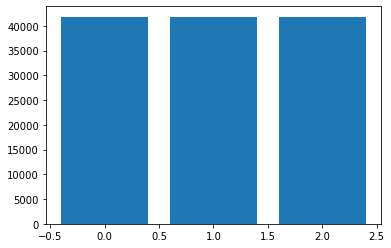

In [6]:
## Count of each class datapoints 
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

# 4- Classification 

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)
rf = RandomForestClassifier()
y_pred = rf.fit(X_train, y_train)
classes = [0, 1 , 2]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(rf, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.832 (0.006)


In [ ]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(rf, classes=classes, support=True)
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_estimator'